In [1]:
import os
import warnings
# warnings.filterwarnings('ignore')  # avoid printing out absolute paths

In [2]:
# !pip install pytorch-lightning
# !pip install pytorch-forecasting

In [3]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [4]:
plt.style.use('ggplot')
plt.rc('patch', force_edgecolor=True,edgecolor='black')
plt.rc('hist', bins='auto')

## Load Data
----

In [5]:
data = pd.read_csv('../wrangled_data/training_post_wrangle_small.csv')
data.rename(columns={'date_block_num':'time_idx'}, inplace=True)

In [6]:
data.rename(columns={'item_cnt_month':'volume'}, inplace=True)

In [10]:
data['shop_id'] = data['shop_id'].astype('str')
data['item_id'] = data['item_id'].astype('str')
data['item_name'] = data['item_name'].astype('str')
data['item_category_name'] = data['item_category_name'].astype('str')
data['shop_name'] = data['shop_name'].astype('str')
data['year'] = data['year'].astype('str')
data['month'] = data['month'].astype('str')
data['ID'] = data['ID'].astype('str')

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7282800 entries, 0 to 7282799
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ID                  object 
 1   shop_id             object 
 2   item_id             object 
 3   year                object 
 4   month               object 
 5   volume              int64  
 6   time_idx            int64  
 7   mean_item           float64
 8   mode_item           float64
 9   item_name           object 
 10  item_category_id    int64  
 11  item_category_name  object 
 12  shop_name           object 
dtypes: float64(2), int64(3), object(8)
memory usage: 722.3+ MB


In [12]:
# group_ids=["agency", "sku"]  # ['shop_id', 'item_id', 'item_name', 'item_category_name', 'shop_name']
# static_categoricals=["agency", "sku"] #['shop_id', 'item_id', 'item_name', 'item_category_name', 'shop_name']
# static_reals=["avg_population_2017", "avg_yearly_household_income_2017"] # ['mean_item', 'mode_item']
# time_varying_known_categoricals=["special_days", "month"]  # ['year', 'month']

In [19]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=['ID', 'shop_id', 'item_id'],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=['shop_id', 'item_id', 'item_name', 'item_category_name', 'shop_name'],
    static_reals=['mean_item', 'mode_item'],
    time_varying_known_categoricals=['year', 'month'],
#     variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
#         "log_volume",
#         "industry_volume",
#         "soda_volume",
#         "avg_max_temp",
#         "avg_volume_by_agency",
#         "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=['ID', 'shop_id', 'item_id'], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=8)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=8)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/data/encoders.py:621: UserWarning:

scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability



## Create Baseline Model

Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.

In [14]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



0.35832321643829346

## Train the Temporal Fusion Transformer

It is now time to create our **TemporalFusionTransformer** model. We train the model with PyTorch Lightning.  

## Find Optimal Learning Rate

Prior to training, you can identify the optimal learning rate with the **PyTorch Lightning learning rate finder.**

In [15]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 187.4k


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1280. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Global seed set to 42
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the n

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

Restoring states from the checkpoint path at /home/ec2-user/SageMaker/Forecast_Product_Demand/TFT/lr_find_temp_model_6c7b00d3-df7a-47be-baec-6bc727b284aa.ckpt


suggested learning rate: 0.6456542290346551


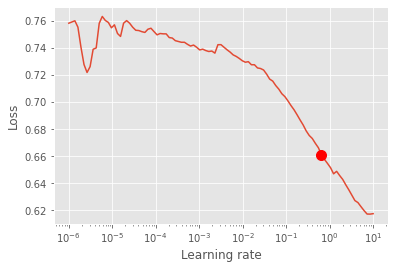

In [16]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=100.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

For the **TemporalFusionTransformer**, the optimal learning rate seems to be slightly lower than the suggested one. Further, we do not directly want to use the suggested learning rate because PyTorch Lightning sometimes can get confused by the noise at lower learning rates and suggests rates far too low. Manual control is essential. We decide to pick 0.03 as learning rate.

## Train Model

If you have troubles training the model and get an error AttributeError: module `tensorflow._api.v2.io.gfile` has no attribute `get_filesystem`, consider either uninstalling tensorflow or first execute

`import tensorflow as tf import tensorboard as tb tf.io.gfile = tb.compat.tensorflow_stub.io.gfile`.

In [17]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    log_every_n_steps=5
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Number of parameters in network: 187.4k


In [18]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
#     enable_model_summary=False,
#     enable_progress_bar = False,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 165 K 
3  | prescalers                         | ModuleDict                      | 128   
4  | static_variable_selection          | VariableSelectionNetwork        | 4.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 2.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.4 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning:

The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/utilities/data.py:60: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 440. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



## Hyperparameter Tuning

Hyperparamter tuning with [optuna](https://optuna.org/) is directly build into pytorch-forecasting. For example, we can use the **optimize_hyperparameters()** function to optimize the TFT’s hyperparameters.

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

## Evaluate Performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

After training, we can make predictions with **predict()**. The method allows very fine-grained control over what it returns so that, for example, you can easily match predictions to your pandas dataframe. See its documentation for details. We evaluate the metrics on the validation dataset and a couple of examples to see how well the model is doing. Given that we work with only 21 000 samples the results are very reassuring and can compete with results by a gradient booster. We also perform better than the baseline model. Given the noisy data, this is not trivial.

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

We can now also look at sample predictions directly which we plot with **plot_prediction()**. As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## Worst Performers

Looking at the worst performers, for example in terms of SMAPE, gives us an idea where the model has issues with forecasting reliably. These examples can provide important pointers about how to improve the model. This kind of actuals vs predictions plots are available to all models. Of course, it is also sensible to employ additional metrics, such as MASE, defined in the metrics module. However, for the sake of demonstration, we only use SMAPE here.

In [ ]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

## Actuals vs Predictions by Variables

Checking how the model performs across different slices of the data allows us to detect weaknesses. Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the calculate_prediction_actual_by_variable() and plot_prediction_actual_by_variable() methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Predict on selected data

To predict on a subset of data we can filter the subsequences in a dataset using the filter() method. Here we predict for the subsequence in the training dataset that maps to the group ids “Agency_01” and “SKU_01” and whose first predicted value corresponds to the time index “15”. We output all seven quantiles. This means we expect a tensor of shape `1 x n_timesteps x n_quantiles = 1 x 6 x 7` as we predict for a single subsequence six time steps ahead and 7 quantiles for each time step.

In [ ]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

Of course, we can also plot this prediction readily:

In [ ]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

## Predict on New Data

Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.